In [2]:
###########
# PRELUDE #
###########

# auto-reload changed python files
%load_ext autoreload
%autoreload 2

# Format cells with %%black
%load_ext blackcellmagic

# nice interactive plots
%matplotlib inline

# add repository directory to include path
from pathlib import Path
import sys
PROJECT_DIR = Path('../..').resolve()
sys.path.append(str(PROJECT_DIR))

import inspect
def _acceptable_global(name, value):
    """Returns True if a global variable with name/value can be safely ignored"""
    return (
        # stuff that's normal to share everywhere
        inspect.isroutine(value) or
        inspect.isclass(value) or
        inspect.ismodule(value) or
        # leading underscore marks private variables
        name.startswith('_') or
        # all-caps names indicate constants
        name.upper() == name or
        # ignore IPython stuff
        name in {'In', 'Out'} or 
        getattr(value, '__module__', '').startswith('IPython'))

def assert_globals_clean():
    """Raises an assertion error if there are unmanaged global variables.
       Variables that are considered 'managed' include those formatted with 
       ALL_CAPS (constants), _a_leading_underscore (recognized as a global but at
       least indicated as private to the cell), classes and modules, automatic
       imports from IPython, and functions generally."""
    unmanaged_globals = {k:type(v) for k, v in globals().items() if not _acceptable_global(k, v)}
    if unmanaged_globals != {}:
        raise AssertionError(f"Unmanaged globals found: {unmanaged_globals}")
    ok("No unmanaged globals detected")

from IPython.display import display, Markdown, HTML

def markdown(s):
    return display(Markdown(s))

def html(s):
    return display(HTML(s))

def ok(message="OK"):
    html(f"<div class=\"alert alert-block alert-success\">{message}</div>")

display(HTML("""
<style>
.custom-assignment-text {
    background-color: lightyellow;
    border: 1px solid darkkhaki; 
    padding: 10px;
    border-radius: 2px
}
</style>"""))

markdown("#### Custom functionality enabled:")
markdown("* Format a code cell by entering %%black at the top of it")
markdown("* Surround markdown cells with  `<div class=\"custom-assignment-text\">\\n\\n ... \\n\\n</div>` to format course-provided assignment text")
markdown("* Use `ok(<message>)` to notify of a passing test")
markdown("* Use `assert_globals_clean()` to check that all globals are managed (private, constants, etc.)")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


#### Custom functionality enabled:

* Format a code cell by entering %%black at the top of it

* Surround markdown cells with  `<div class="custom-assignment-text">\n\n ... \n\n</div>` to format course-provided assignment text

* Use `ok(<message>)` to notify of a passing test

* Use `assert_globals_clean()` to check that all globals are managed (private, constants, etc.)

<div class="custom-assignment-text">

## Goal of mini-project

In the three problems of this mini-project, you will explore the idea of generalization, i.e., when the test error of a learned prediction function is roughly the same as its training error. You will explore how regularization and the choice of the learning algorithm (gradient descent, stochastic gradient descent, etc.) interact with generalization in a simple linear prediction setting.1 Many aspects of these relationships are still not well understood, and a fierce debate is currently raging within the Machine Learning community about whether our understanding of generalization lacks key components necessary for explaining the unreasonable effectiveness of stochastic gradient descent (particularly in the context of “deep learning”). This week will give you a glimpse of some of these mysteries.

</div>

<div class="custom-assignment-text">

# Part 1: Regression, Three Ways

<!-- LaTeX shortcuts defined first -->$\def\a{{\mathbf a}}\def\x{{\mathbf x}}$We will consider the problem of fitting a linear model. Given $d$-dimensional input data $\x^{(1)}, \cdots, \x^{(n)} ∈ ℝ^d$ with real-valued labels $y^{(1)},\cdots, y^{(n)} ∈ ℝ$, the goal is to find the coefficient vector $\a$ that minimizes the sum of the squared errors. The total squared error of $\a$ can be written as $f(\a) = \sum_{i=1}^{n} f_i(\a)$, where $f_i(\a)=(\a^\top\x^{(i)} - $ $y^{(i)})^2$ denotes the squared error of the $i$th data point.

The data in this problem will be drawn from the following linear model. For the training data, we select $n$ data points $\x^{(1)}, \cdots, \x^{(n)}$, each drawn independently from a $d$-dimensional Gaussian distribution. We then pick the "true" coefficient vector $\a^*$ (again from a $d$-dimensional Gaussian), and give each training point $\x^{(i)}$ a label equal to $(\a^*)^\top\x^{(i)}$ plus some noise (which is drawn from a 1-dimensional Gaussian distribution).

The following Python code will generate the data used in this problem.

    d = 100 # dimensions of data
    n = 1000 # number of data points
    X = np.random.normal(0,1, size=(n,d))
    a_true = np.random.normal(0,1, size=(d,1))
    y = X.dot(a_true) + np.random.normal(0,0.5,size=(n,1))

</div>

In [72]:
import matplotlib.pyplot as plt
import numpy as np

<div class="custom-assignment-text">

<!-- LaTeX shortcuts defined first -->$\def\X{{\mathbf X}}\def\y{{\mathbf y}}$(a) (4 points) Least-squares regression has the closed form solution $\a = (\X^\top\X)^{-1}\X^\top\y$, which minimizes the squared error on the data. (Here $\X$ is the $n×d$ data matrix as in the code above, with one row per data point, and $y$ is the $n$-vector of their labels.) Solve for $\a$ and report the value of the objective function using this value $\a$. For comparison, what is the total squared error if you just set $\a$ to be the all 0’s vector?

Comment: Computing the closed-form solution requires time $O(nd^2+d^3)$, which is slow for large $d$. Although gradient descent methods will not yield an exact solution, they do give a close approximation in much less time. For the purpose of this assignment, you can use the closed form solution as a good sanity check in the following parts.

</div>

In [4]:
def get_part1_data():
    d = 100 # dimensions of data
    n = 1000 # number of data points
    X = np.random.normal(0,1, size=(n,d))
    a_true = np.random.normal(0,1, size=(d,1))
    y = X.dot(a_true) + np.random.normal(0,0.5,size=(n,1))
    return X, y
PART1_X, PART1_Y = get_part1_data()

In [5]:
def least_squares_regression_closed_form(X, y):
    a = np.linalg.inv(X.T @ X) @ X.T @ y
    assert a.shape == (X.shape[1], 1)
    return a

In [106]:
def error(a, X, y):
    assert a.T.shape[1] == X.shape[1]
    assert X.shape[0] == y.shape[0]
    return (a.T @ X.T - y.T)

def squared_error(a, X, y):
    return error(a, X, y)**2

def total_squared_error(a, X, y):
    return squared_error(a, X, y).sum()

def mean_squared_error(a, X, y):
    error = squared_error(a, X, y)
    return error.sum() / X.shape[1]

In [108]:
def _estimate_and_report_errors(X, y):
    a_estimate = least_squares_regression_closed_form(X, y)
    a_error = mean_squared_error(a_estimate, X, y)
    all_zeros_error = mean_squared_error(np.zeros((X.shape[1], 1)), X, y)
    markdown(f"* MSE using closed-form solution: {a_error}")
    markdown(f"* MSE using all-zeros solution: {all_zeros_error}")

_estimate_and_report_errors(PART1_X, PART1_Y)

* Error using closed-form solution: 2.1903207123677566

* Error using all-zeros solution: 1149.3412035177782

<div class="custom-assignment-text">
    
(b) (6 points) In this part, you will solve the same problem via gradient descent on the squared-error
objective function $f(\a) = \sum_{i=1}^n f_i(\a)$. Recall that the gradient of a sum of functions is the sum of their gradients. Given a point $\a_t$, what is the gradient of $f$ at $\a_t$?
    
Now use gradient descent to find a coefficient vector $\a$ that approximately minimizes the least squares
objective function over the data. Run gradient descent three times, once with each of the step sizes
0.00005, 0.0005, and 0.0007. You should initialize $\a$ to be the all-zero vector for all three runs. Plot the objective function value for 20 iterations for all 3 step sizes on the same graph. Comment in 3-4 sentences on how the step size can affect the convergence of gradient descent (feel free to experiment
with other step sizes). Also report the step size that had the best final objective function value and
the corresponding objective function value.
    
</div>

The gradient for MSE given in the lecture notes is as follows:

$\nabla f({\mathbf w}) = \frac{2}{m}\sum_{i=1}^m (E_i({\mathbf w}) \cdot \x^{(i)})$, where $E_i({\mathbf w}) = h_w(\x^{(i)}) - y^{(i)}$.

In [109]:
def mse_gradient(w, X, y):
    """Returns: (gradient of MSE at w, error value at w)"""
    w_error = error(w, X, y)
    grad = np.dot(w_error, X) * 2 / X.shape[0]
    assert grad.shape == (1, X.shape[1])
    return grad, mean_squared_error(w, X, y)

def gradient_descent(X, y, step_size, iterations):
    """Returns (weights, [loss for each iteration])"""
    w = np.zeros((X.shape[1], 1))
    loss = []
    for _ in range(iterations):
        gradient, total_error = mse_gradient(w, X, y)
        loss.append(total_error)
        update = step_size * gradient.T
        w -= update
        distance_moved = np.linalg.norm(update)
    return w, loss
    

* Final loss with step size 5e-05 after 20 iterations: 1144.3188147774192

* Final loss with step size 0.0005 after 20 iterations: 1100.1558098848334

* Final loss with step size 0.0007 after 20 iterations: 1081.1144372855397

* Final loss with step size 0.007 after 20 iterations: 630.5953339875679

* Final loss with step size 0.07 after 20 iterations: 10.981910177782327

* Final loss with step size 0.1 after 20 iterations: 3.960269510713023

* Final loss with step size 0.2 after 20 iterations: 2.2019854815295195

* Final loss with step size 0.3 after 20 iterations: 2.190387566553755

* Final loss with step size 0.4 after 20 iterations: 2.190320933398429

* Final loss with step size 0.5 after 20 iterations: 2.190416966699528

* Final loss with step size 0.6 after 20 iterations: 330.2589934713719

* Final loss with step size 0.7 after 20 iterations: 15481925.271207027

* Final loss with step size 0.8 after 20 iterations: 67735920651.30758

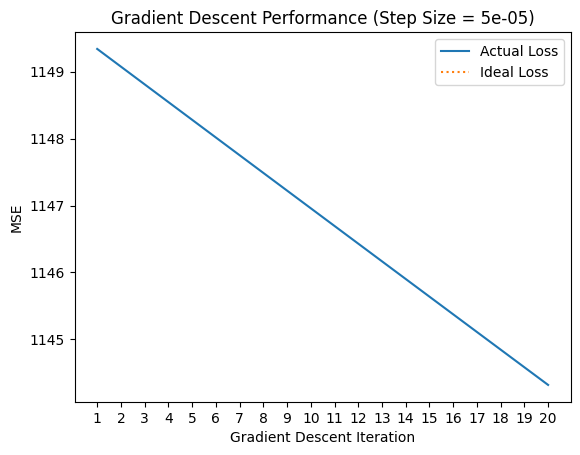

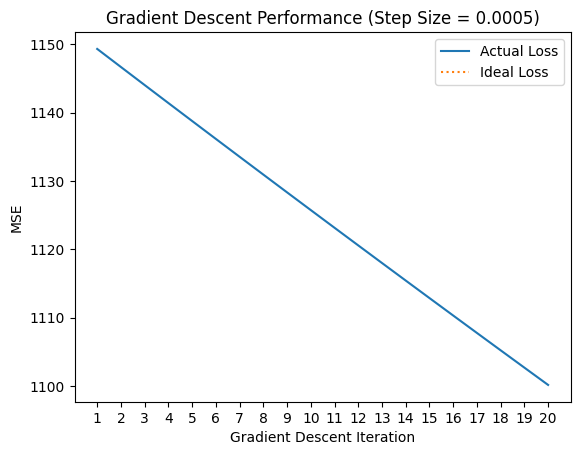

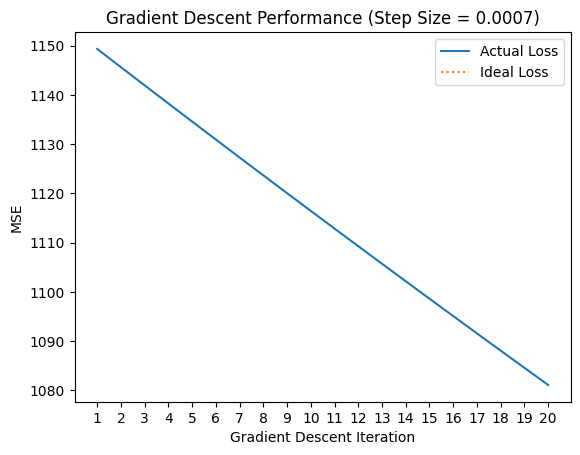

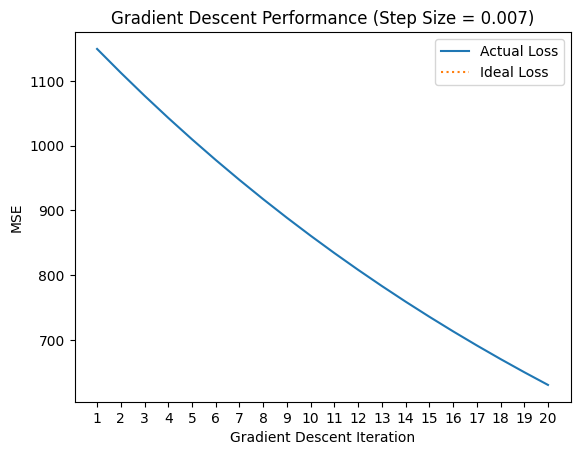

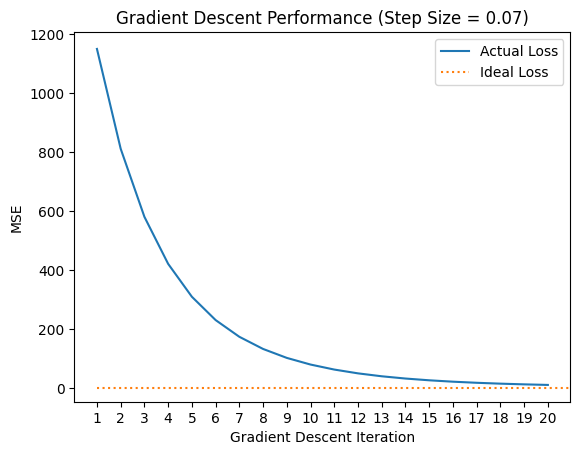

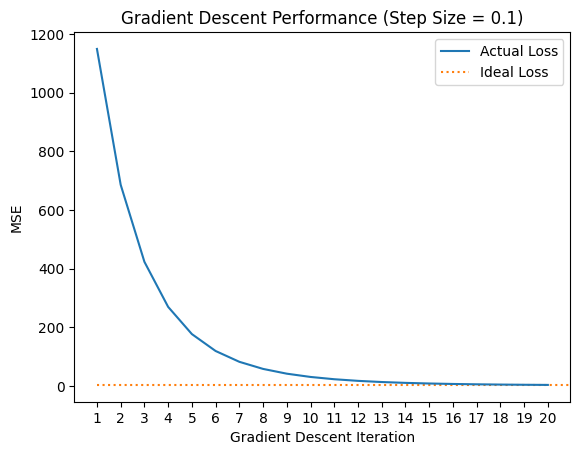

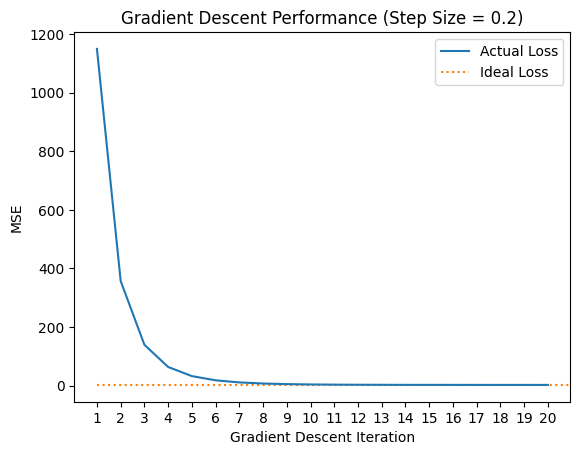

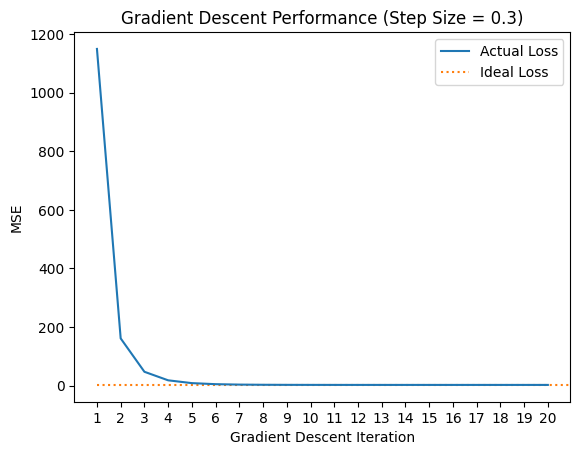

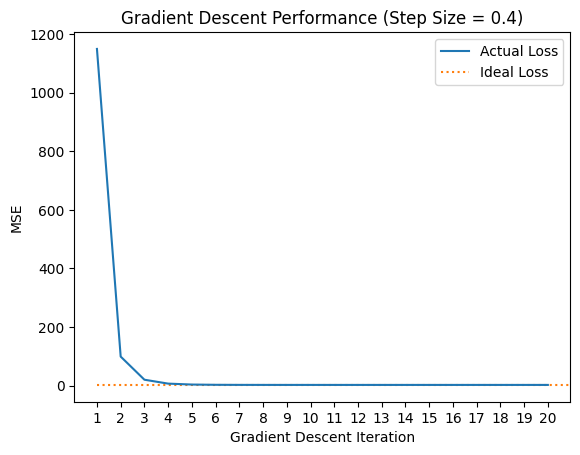

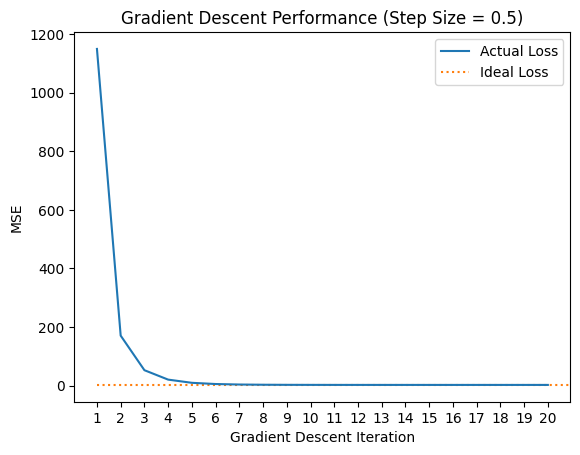

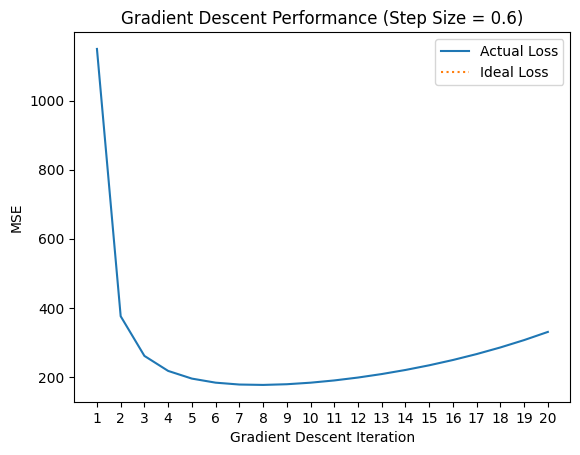

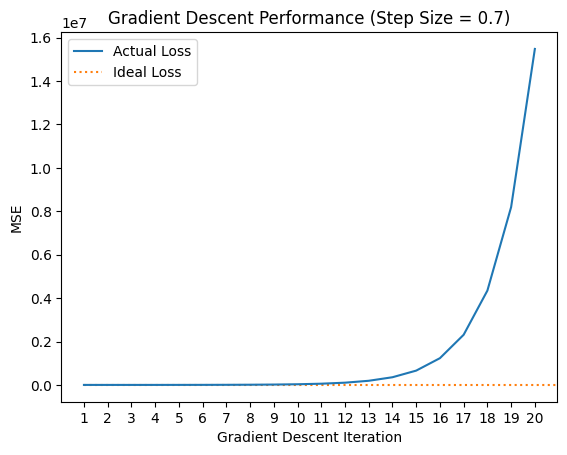

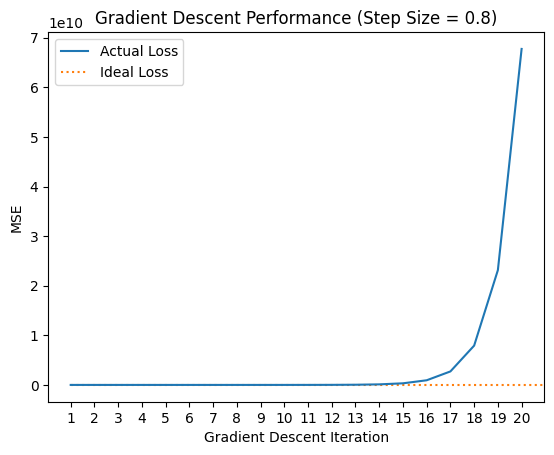

In [144]:
def _run_and_report_gradient_descent(X, y, step_size, ideal_loss, iterations=20):
    a, loss = gradient_descent(PART1_X, PART1_Y, step_size, iterations)
    markdown(f"* Final loss with step size {step_size} after 20 iterations: {loss[-1]}")
    
    fig, ax = plt.subplots()
    xticks = range(1, iterations + 1)
    ax.plot(xticks, loss, label="Actual Loss")
    ax.set_title(f"Gradient Descent Performance (Step Size = {step_size})")
    ax.set_ylabel("MSE")
    ax.set_xlabel("Gradient Descent Iteration")
    ax.set_xticks(xticks)
    # avoid re-scaling the plot just to fit the ideal loss line
    ax.autoscale(False)
    ax.hlines(ideal_loss, 1, iterations + 1, linestyles='dotted', colors='C1', label="Ideal Loss")
    plt.legend(loc="best")

for step_size in [0.00005, 0.0005, 0.0007, 0.007, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    _run_and_report_gradient_descent(PART1_X, PART1_Y, step_size, 2.1903207123677566)

Step-sizes .2, .3, .4, and .5 all led to MSE values within 0.01 of the ideal (closed) solution. Higher values, however, led to quicker convergence on this value, with 0.4 being the fastest convering value. 0.5 and higher led to divergence.

<div class="custom-assignment-text">

(c) (6 points) In this part you will run _stochastic gradient descent_ to solve the same problem. Recall
that in stochastic gradient descent, you pick one datapoint at a time, say $(\x^{(i)}, y^{(i)})$, and update your current value of $\a$ according to the gradient of $f_i(\a) = (\a\top \x^{(i)} - y^{(i)})^2$.
    
Run stochastic gradient descent using step sizes {0.0005, 0.005, 0.01} and 1000 iterations. Plot the objective function value vs. the iteration number for all 3 step sizes on the same graph. Comment 3-4 sentences on how the step size can affect the convergence of stochastic gradient descent and how it compares to gradient descent. Compare the performance of the two methods. How do the best final objective function values compare? How many times does each algorithm use each data point? Also report the step size that had the best final objective function value and the corresponding objective function value.

</div>